In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import torch
import torch.nn as nn
import torch.distributions as dists
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions.distribution import Distribution
from np_utils import simple_data, curved_data, planck_des_data
from torch_utils import rotation_test, get_limits, TrainUtil
from tension_net import TensionNet, TensionNet1, TensionNet2, TensionNet3
from tension_quantify import GaussianKDE, BayesFactorKDE, SuspiciousnessKDE, sigma_from_logS

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
X0, X1, X_prior = simple_data(dims=2)

In [ ]:
start = time.time()
tension_R = TensionNet1(2, hidden_size=4096)
criterion = BayesFactorKDE(device, n_points=500)
optimizer = optim.Adam(tension_R.parameters(), lr=0.001)

train_util_R = TrainUtil(tension_R, optimizer, criterion, device)
losses_R = train_util_R.train(X0, X1, X_prior, n_iter=60)
print("Histogram time taken: ", time.time() - start)

Histogram time taken:  2.7036261558532715


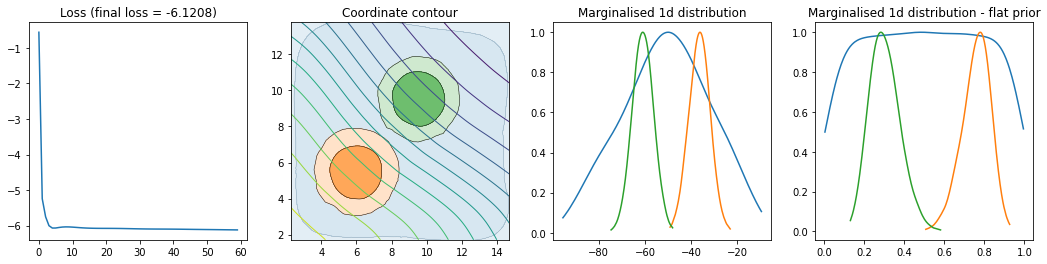

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
# fig.suptitle("Two Gaussians, comparing histogram method and KDE method")

train_util_R.plot_loss(axs[0])
train_util_R.visualise_coordinate(axs[1], norm_tension=True)
train_util_R.plot_marginalised_dists(axs[2])
train_util_R.plot_marginalised_dists(axs[3], flat_prior=True)

In [ ]:
torch.save(train_util_R.net.state_dict(), "report_plots/toy_simple.pt")

In [ ]:
X0_c, X1_c, X_prior_c = curved_data(banana="circle")

In [ ]:
start = time.time()
tension_R_c = TensionNet1(2, hidden_size=4096)
criterion = BayesFactorKDE(device, n_points=500)
optimizer = optim.Adam(tension_R_c.parameters(), lr=0.001)

train_util_R_c = TrainUtil(tension_R_c, optimizer, criterion, device)
losses_R_c = train_util_R_c.train(X0_c, X1_c, X_prior_c, n_iter=500)
print("Histogram time taken: ", time.time() - start)

Histogram time taken:  29.466240167617798


In [ ]:
moving_average = [np.average(losses_R_c[i - 100:i]) for i in range(100, len(losses_R_c))]

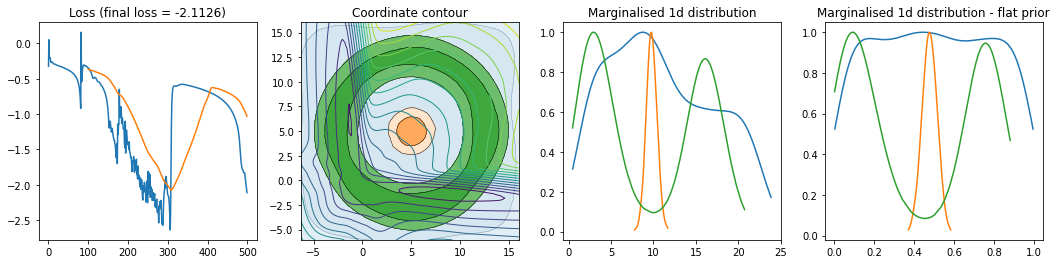

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

train_util_R_c.plot_loss(axs[0])
axs[0].plot(range(100, len(losses_R_c)), moving_average)
train_util_R_c.visualise_coordinate(axs[1], norm_tension=False)
train_util_R_c.plot_marginalised_dists(axs[2])
train_util_R_c.plot_marginalised_dists(axs[3], flat_prior=True)

In [ ]:
torch.save(train_util_R_c.net.state_dict(), "report_plots/toy_curved.pt")

In [ ]:
params = ["omegabh2", "omegam", "H0", "tau", "sigma8", "ns"]
param_pairs = []
param_labels = [r"$\Omega_b h^2$", r"$\Omega_m$", r"$H_0$", r"$\tau$", r"$\sigma_8$", r"$n_s$"]
for i in range(len(params)):
    for j in range(i + 1, len(params)):
        param_pairs.append([i, j])

In [ ]:
(X0, X0_weights, X1, X1_weights, X_prior, X_prior_weights,
 params, param_means, norm_factors) = planck_des_data(
     params=params, div_max=True
)
weights = { "XA": X0_weights, "XB": X1_weights, "X_prior": X_prior_weights }
param_means = torch.tensor(param_means).float().to(device)
norm_factors = torch.tensor(norm_factors).float().to(device)

Assuming Gaussian distributions, logR:  -0.626890816225358


In [ ]:
start = time.time()
tension_R_cosmo = TensionNet1(6, hidden_size=4096)
criterion = SuspiciousnessKDE(device, n_points=500)
optimizer = optim.Adam(tension_R_cosmo.parameters(), lr=0.0001)

train_util_R_cosmo = TrainUtil(tension_R_cosmo, optimizer, criterion, device)
losses_R_cosmo = train_util_R_cosmo.train(X0, X1, X_prior, weights=weights,
                                                n_iter=500, decrease_lr_at=[-8])
print("Histogram time taken: ", time.time() - start, "Final Loss: ", losses_R_cosmo[-1])

Histogram time taken:  54.30398678779602 Final Loss:  -25.310007095336914


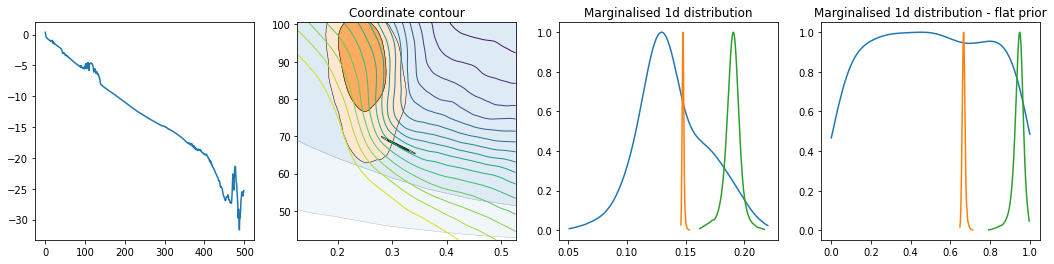

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# train_util_R_cosmo.plot_loss(axs[0])
axs[0].plot(losses_R_cosmo[:500])
train_util_R_cosmo.visualise_coordinate(axs[1], norm_tension=True, idxs=(1, 2), param_means=param_means, norm_factors=norm_factors, swap_order=True)
train_util_R_cosmo.plot_marginalised_dists(axs[2])
train_util_R_cosmo.plot_marginalised_dists(axs[3], flat_prior=True)

/content/drive/My Drive/project/torch_utils.py:440: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


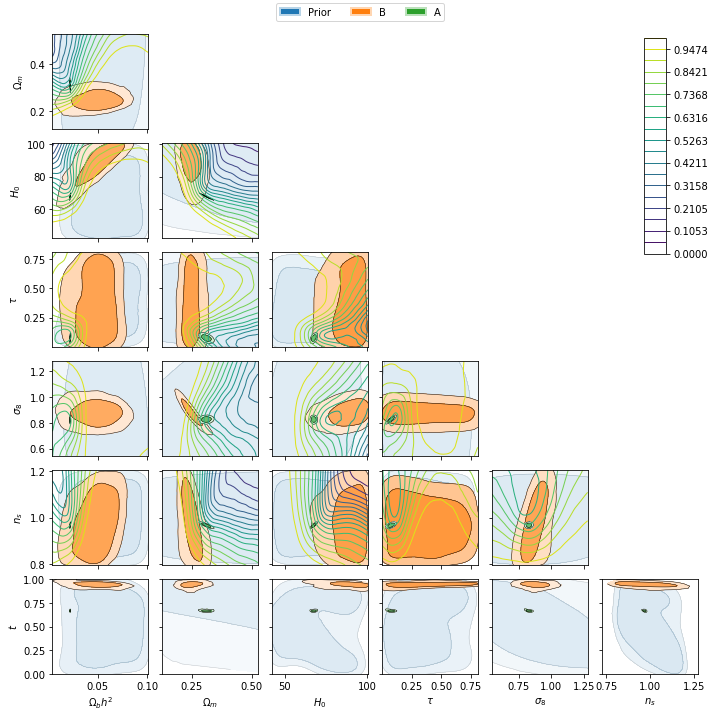

In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10), sharex='col', sharey='row')
train_util_R_cosmo.visualise_coordinates_all(
    fig, axs, param_names=params,
    sync_levels=True, tension_as_param=True, focus='both', pad_div=100,
    swap_order=True, param_means=param_means, norm_factors=norm_factors,
    norm_tension=True
)

for i in range(6):
    for j in range(6):
        if i != 5 and j != 0:
            axs[i, j].set_xlabel("")
            axs[i, j].set_ylabel("")
        elif i == 5 and j != 0:
            axs[i, j].set_ylabel("")
            axs[i, j].set_xlabel(param_labels[j])
        elif i != 5 and j == 0:
            axs[i, j].set_xlabel("")
            axs[i, j].set_ylabel(param_labels[i + 1])
        elif i == 5 and j == 0:
            axs[i, j].set_xlabel(param_labels[j])
            axs[i, j].set_ylabel(r"$t$")

        if i == 5:
            # axs[i, j].set_ylim([0.725, 0.825])
            axs[i, j].set_ylim([0, 1])

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1))
fig.tight_layout(rect=[0, 0, 1, 0.97])

plt.subplots_adjust(hspace=0.15, wspace=0.15)

In [ ]:
for i in range(6):
    min_logRs = []
    final_logRs = []
    for iter in range(5):
        start = time.time()
        tension_R_cosmo = TensionNet1(5, hidden_size=4096)
        criterion = BayesFactorKDE(device, n_points=500)
        optimizer = optim.Adam(tension_R_cosmo.parameters(), lr=0.0001)

        train_util_R_cosmo = TrainUtil(tension_R_cosmo, optimizer, criterion, device)
        losses_R_cosmo = train_util_R_cosmo.train(np.delete(X0, i, axis=1), np.delete(X1, i, axis=1), np.delete(X_prior, i, axis=1), weights=weights,
                                                        n_iter=500, decrease_lr_at=[8])
        min_logRs.append(min(losses_R_cosmo))
        final_logRs.append(losses_R_cosmo[-1])
        print("Histogram time taken: ", time.time() - start, "Final Loss: ", losses_R_cosmo[-1])
    print("Min", min_logRs)
    print("Final", final_logRs)

Histogram time taken:  42.39917874336243 Final Loss:  -8.51870346069336
Histogram time taken:  42.471070289611816 Final Loss:  -10.624075889587402
Histogram time taken:  42.390751123428345 Final Loss:  -4.2610368728637695
Histogram time taken:  42.46917152404785 Final Loss:  -11.634572982788086
Histogram time taken:  42.36582612991333 Final Loss:  -7.493312358856201
Min [-12.691052436828613, -11.191776275634766, -9.881887435913086, -11.634572982788086, -10.319181442260742]
Final [-8.51870346069336, -10.624075889587402, -4.2610368728637695, -11.634572982788086, -7.493312358856201]
Histogram time taken:  42.41679334640503 Final Loss:  -6.676029205322266
Histogram time taken:  42.383464336395264 Final Loss:  -6.984545707702637
Histogram time taken:  42.369118452072144 Final Loss:  -10.076887130737305
Histogram time taken:  42.344608545303345 Final Loss:  -8.60403060913086
Histogram time taken:  42.32624554634094 Final Loss:  -8.675921440124512
Min [-6.676029205322266, -6.984545707702637, 

In [ ]:
for i in range(6):
    min_logRs = []
    final_logRs = []
    for iter in range(5):
        start = time.time()
        tension_R_cosmo = TensionNet1(5, hidden_size=4096)
        criterion = BayesFactorKDE(device, n_points=500)
        optimizer = optim.Adam(tension_R_cosmo.parameters(), lr=0.0001)

        train_util_R_cosmo = TrainUtil(tension_R_cosmo, optimizer, criterion, device)
        losses_R_cosmo = train_util_R_cosmo.train(np.delete(X0, i, axis=1), np.delete(X1, i, axis=1), np.delete(X_prior, i, axis=1), weights=weights,
                                                        n_iter=500, decrease_lr_at=[8])
        min_logRs.append(min(losses_R_cosmo))
        final_logRs.append(losses_R_cosmo[-1])
        print("Histogram time taken: ", time.time() - start, "Final Loss: ", losses_R_cosmo[-1])
    print("Min", min_logRs)
    print("Final", final_logRs)

Histogram time taken:  42.25753140449524 Final Loss:  -2.4708847999572754
Histogram time taken:  42.24660086631775 Final Loss:  -3.0538012981414795
Histogram time taken:  42.19930863380432 Final Loss:  -3.5193145275115967
Histogram time taken:  42.20758366584778 Final Loss:  -9.433560371398926
Histogram time taken:  42.29667592048645 Final Loss:  -7.552791118621826
Min [-2.4708847999572754, -9.290071487426758, -3.5193145275115967, -12.01191520690918, -14.407450675964355]
Final [-2.4708847999572754, -3.0538012981414795, -3.5193145275115967, -9.433560371398926, -7.552791118621826]
Histogram time taken:  42.26614332199097 Final Loss:  -7.286812782287598
Histogram time taken:  42.19245624542236 Final Loss:  -2.6388323307037354
Histogram time taken:  42.273842096328735 Final Loss:  -2.8735082149505615
Histogram time taken:  42.2539439201355 Final Loss:  -5.853264808654785
Histogram time taken:  42.245914459228516 Final Loss:  -7.885683536529541
Min [-7.286812782287598, -2.7507028579711914, 

In [ ]:
min(losses_R_cosmo)

-9.245434761047363

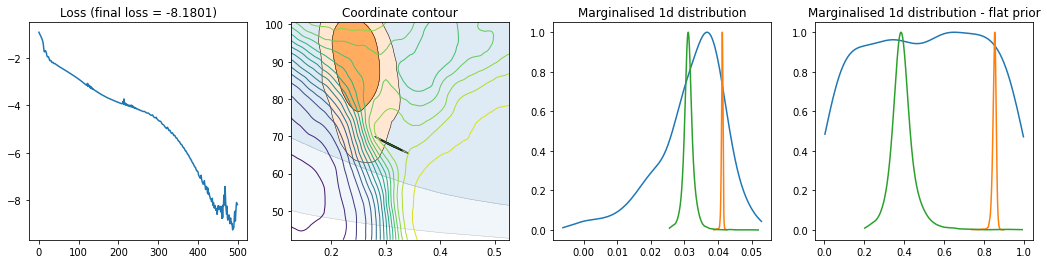

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

train_util_R_cosmo.plot_loss(axs[0])
train_util_R_cosmo.visualise_coordinate(
    axs[1], norm_tension=True, idxs=(1, 2), 
    param_means=torch.cat((param_means[:3], param_means[4:])), 
    norm_factors=torch.cat((norm_factors[:3], norm_factors[4:])), 
    swap_order=True)
train_util_R_cosmo.plot_marginalised_dists(axs[2])
train_util_R_cosmo.plot_marginalised_dists(axs[3], flat_prior=True)

In [ ]:
rand0 = torch.rand(X0.shape[0])
rand1 = torch.rand(X1.shape[0])
rand_prior = torch.rand(X_prior.shape[0])

param_range = [tup[1] - tup[0] for tup in param_lims]
logRs = []
logSs = []
bf = BayesFactorKDE(device)

for j in range(6):
    util = train_util_R_cosmo

    XA_perm = util.XA_tnsr.clone().detach()
    XB_perm = util.XB_tnsr.clone().detach()
    X_prior_perm = util.X_prior_tnsr.clone().detach()
    X_combine = torch.cat((XA_perm, XB_perm), axis=0)
    X_combine[:, j] = X_combine[torch.randperm(X_combine.shape[0]), j]
    # XA_perm[:, j] = X_combine[:XA_perm.shape[0], j]
    # XB_perm[:, j] = X_combine[XA_perm.shape[0]:, j]
    # X_prior_perm[:, j] = X_prior_perm[torch.randperm(X_prior_perm.shape[0]), j]
    XA_perm[:, j] = (rand0 * param_range[j]) + param_lims[j][0]
    XB_perm[:, j] = (rand1 * param_range[j]) + param_lims[j][0]
    # X_prior_perm[:, j] = rand_prior

    XA_1d = util.net(XA_perm)
    XB_1d = util.net(XB_perm)
    X_prior_1d = util.net(X_prior_perm)
    logR = bf(XA_1d, XB_1d, X_prior_1d, weights=util.weights)
    logS = util.criterion(XA_1d, XB_1d, X_prior_1d, weights=util.weights)
    logRs.append(logR.item())
    logSs.append(logS.item())
    del XA_perm, XB_perm, X_prior_perm, XA_1d, XB_1d, X_prior_1d

In [ ]:
logRs

[0.7107028961181641,
 -0.028263092041015625,
 -0.793302059173584,
 0.9895524978637695,
 -1.009648323059082,
 -2.27457332611084]

In [ ]:
utils = []

for i in range(15, 20):
    start = time.time()
    tension_R_cosmo = TensionNet1(6, hidden_size=4096)
    criterion = BayesFactorKDE(device, n_points=500)
    optimizer = optim.Adam(tension_R_cosmo.parameters(), lr=0.0001)

    train_util_R_cosmo = TrainUtil(tension_R_cosmo, optimizer, criterion, device)
    losses_R_cosmo = train_util_R_cosmo.train(X0, X1, X_prior, weights=weights,
                                                    n_iter=500, decrease_lr_at=[-8])
    print("Histogram time taken: ", time.time() - start, "Final Loss: ", losses_R_cosmo[-1])
    utils.append(train_util_R_cosmo)
    torch.save(train_util_R_cosmo.net.state_dict(), f"nets/kde/six_{i}.pt")
    np.savetxt(f"nets/kde/six_{i}_loss.csv", np.asarray(losses_R_cosmo), delimiter=',')

Histogram time taken:  71.24554538726807 Final Loss:  -15.905625343322754
Histogram time taken:  71.20497059822083 Final Loss:  -11.145363807678223
Histogram time taken:  71.01390075683594 Final Loss:  -6.457285404205322
Histogram time taken:  70.81615805625916 Final Loss:  -15.630382537841797
Histogram time taken:  70.66864514350891 Final Loss:  -12.2305326461792


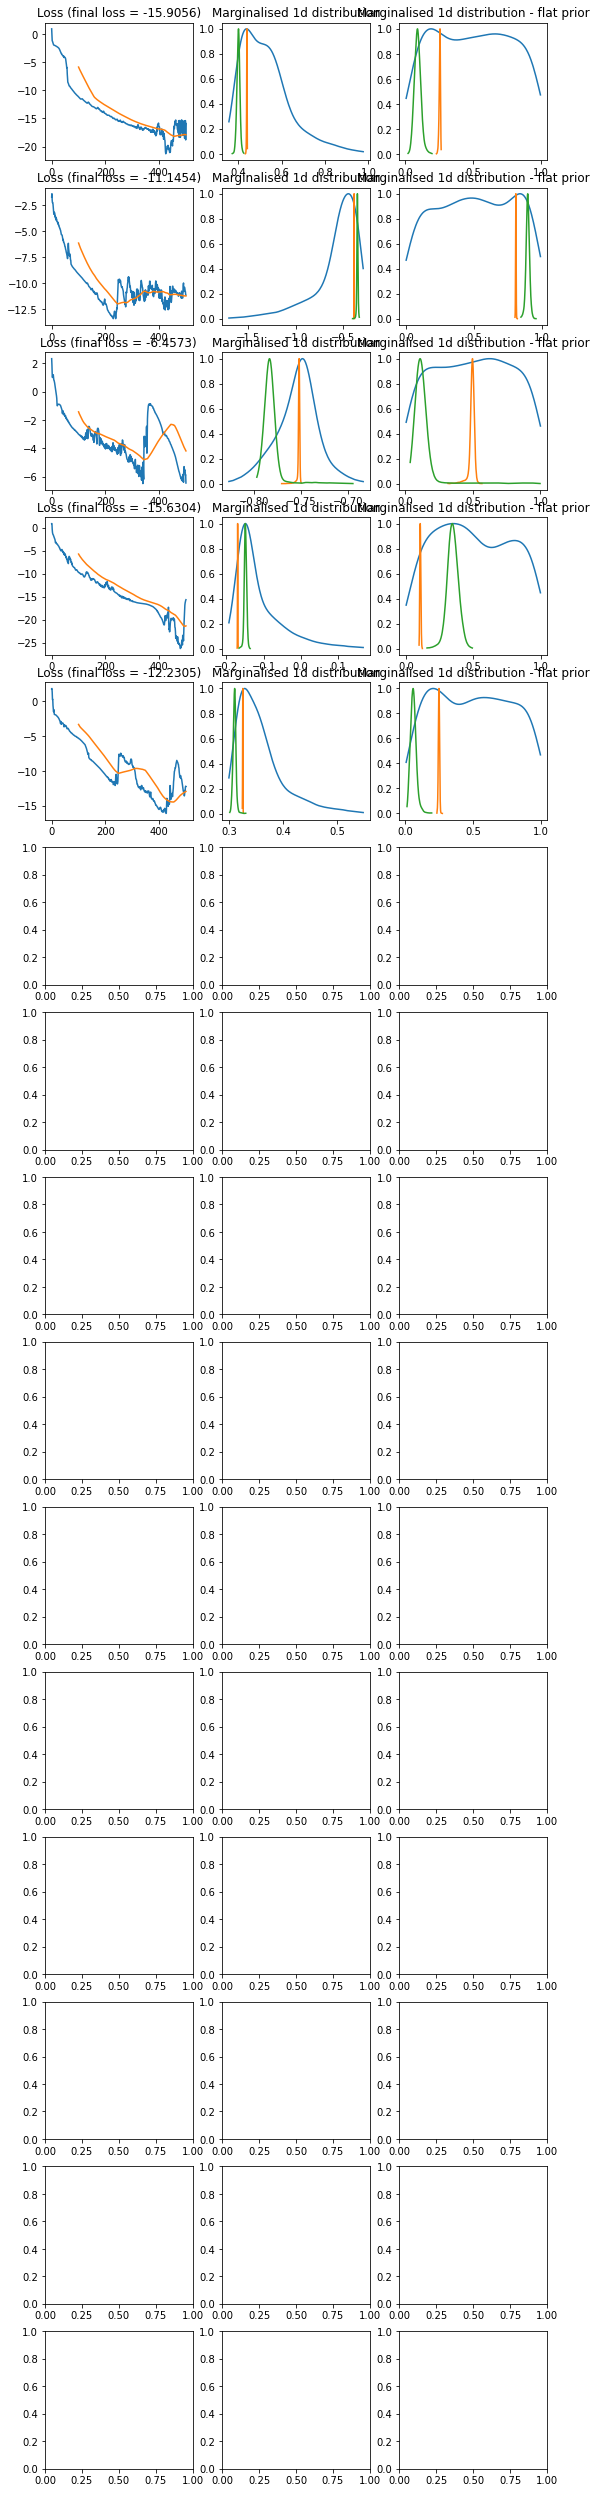

In [ ]:
fig, axs = plt.subplots(15, 3, figsize=(9, 45))

for i, util in enumerate(utils):
    util.plot_loss(axs[i, 0])
    moving_average = [np.average(util.losses[i - 100:i]) for i in range(100, len(util.losses))]
    axs[i, 0].plot(range(100, len(util.losses)), moving_average)
    util.plot_marginalised_dists(axs[i, 1])
    util.plot_marginalised_dists(axs[i, 2], flat_prior=True)

/content/drive/MyDrive/project/torch_utils.py:428: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


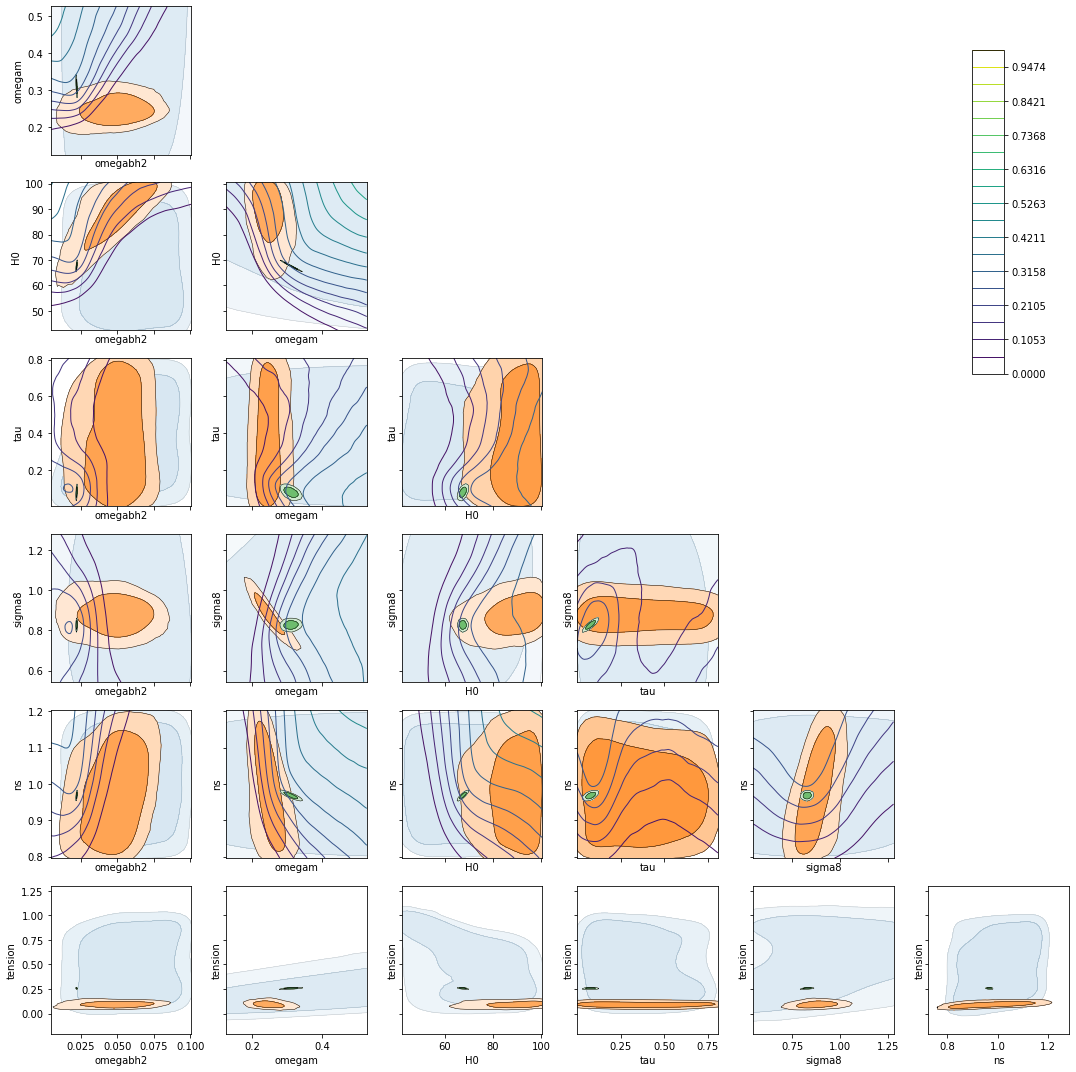

In [ ]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15), sharex='col', sharey='row')

utils[0].visualise_coordinates_all(
    fig, axs, param_names=params,
    sync_levels=True, tension_as_param=True, focus='both', pad_div=100,
    swap_order=True, param_means=param_means, norm_factors=norm_factors,
    norm_tension=True
)

In [ ]:
all_train_utils = []

for pair in param_pairs:
    X0_pair = X0[:, pair]
    X1_pair = X1[:, pair]
    X_prior_pair = X_prior[:, pair]
    start = time.time()
    train_utils_set = []
    losses = []

    for i in range(5):
        tension_pair = TensionNet1(2, hidden_size=4096)
        criterion = BayesFactorKDE(device, n_points=500)
        optimizer = optim.Adam(tension_pair.parameters(), lr=0.0001)

        train_util_pair = TrainUtil(tension_pair, optimizer, criterion, device)
        losses_pair = train_util_pair.train(X0_pair, X1_pair, X_prior_pair,
                                                weights=weights, n_iter=500)
        losses.append(losses_pair[-1])
        
        train_utils_set.append(train_util_pair)
    
    all_train_utils.append(train_utils_set)
    print(f"{pair} Training time taken: ", time.time() - start, "Log R: ", losses)

[0, 1] Training time taken:  20.695982694625854 Log R:  [-2.5683419704437256]
[0, 2] Training time taken:  20.32438850402832 Log R:  [-3.0488009452819824]
[0, 3] Training time taken:  20.34901785850525 Log R:  [-2.0783214569091797]
[0, 4] Training time taken:  20.38844108581543 Log R:  [-3.1305408477783203]
[0, 5] Training time taken:  20.385024785995483 Log R:  [-2.5509305000305176]
[1, 2] Training time taken:  20.41215419769287 Log R:  [-3.3291573524475098]
[1, 3] Training time taken:  20.39096450805664 Log R:  [-3.6097359657287598]
[1, 4] Training time taken:  20.4580340385437 Log R:  [-2.0309910774230957]
[1, 5] Training time taken:  20.35069179534912 Log R:  [-2.4682059288024902]
[2, 3] Training time taken:  20.46480917930603 Log R:  [-3.419642925262451]
[2, 4] Training time taken:  20.486830472946167 Log R:  [-3.187903881072998]
[2, 5] Training time taken:  20.561014652252197 Log R:  [-3.857280731201172]
[3, 4] Training time taken:  20.523759365081787 Log R:  [-2.3700644969940186

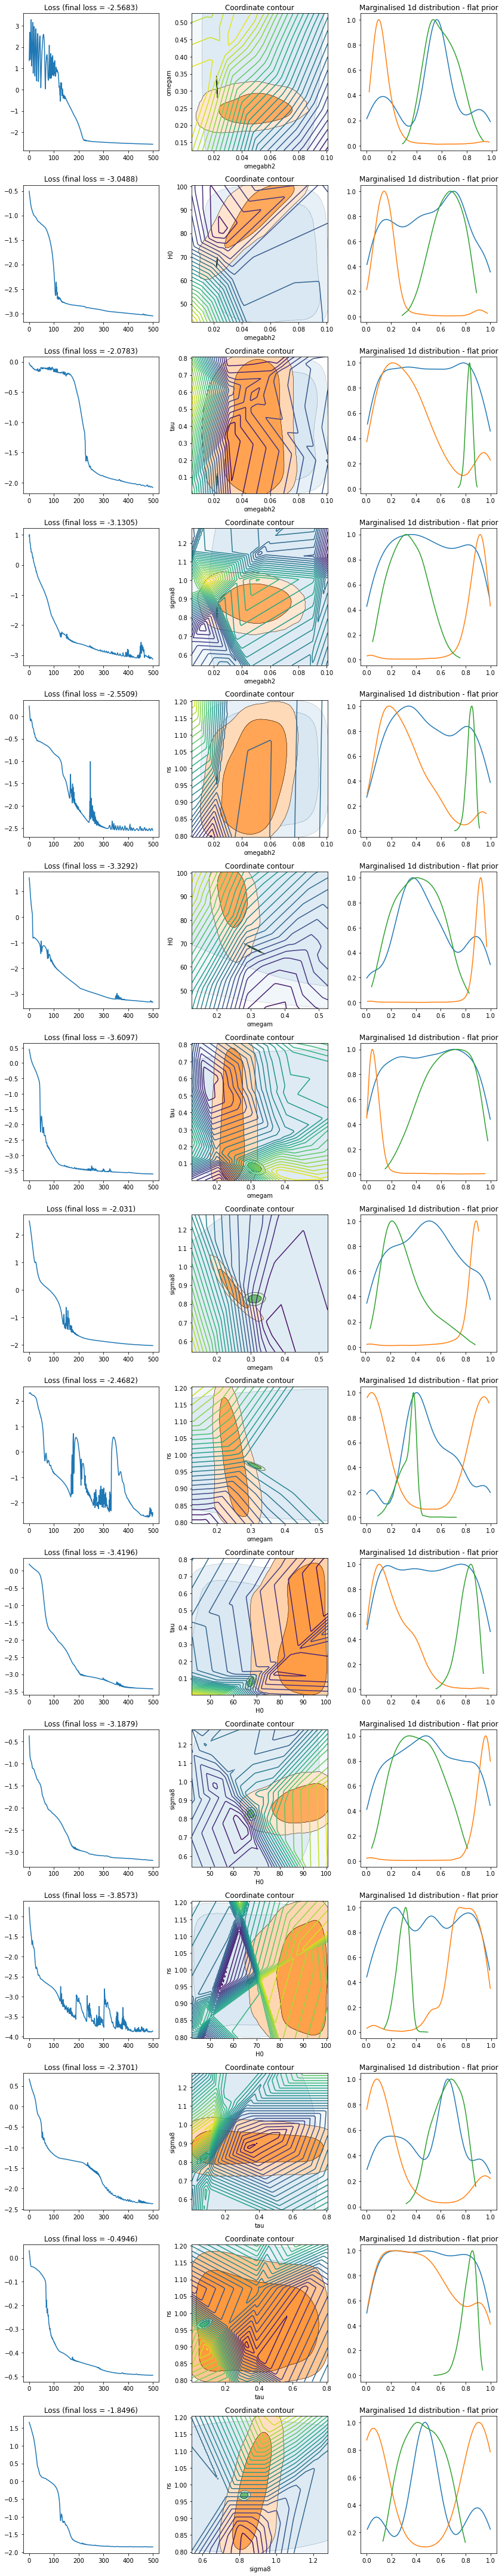

In [ ]:
fig, axs = plt.subplots(len(train_utils), 3, figsize=(12, 4*len(train_utils)))

for i, tutil in enumerate(train_utils):
    tutil.plot_loss(axs[i, 0])
    tutil.visualise_coordinate(
        axs[i, 1], focus='both', pad_div=100, swap_order=True,
        param_means=param_means[param_pairs[i]],
        norm_factors=norm_factors[param_pairs[i]]
    )
    axs[i, 1].set_xlabel(params[param_pairs[i][0]])
    axs[i, 1].set_ylabel(params[param_pairs[i][1]])
    axs[i, 1].set_title(param_pairs[i])
    tutil.plot_marginalised_dists(axs[i, 2], flat_prior=True, swap_order=True)

fig.tight_layout()

In [ ]:
train_utils = []
suss = SuspiciousnessKDE(device)

for pair in param_pairs:
    X0_pair = X0[:, pair]
    X1_pair = X1[:, pair]
    X_prior_pair = X_prior[:, pair]
    start = time.time()
    logRs = []
    logSs = []

    for i in range(5):
        tension_pair = TensionNet1(2, hidden_size=4096)
        criterion = BayesFactorKDE(device, n_points=500)
        optimizer = optim.Adam(tension_pair.parameters(), lr=0.0001)

        train_util_pair = TrainUtil(tension_pair, optimizer, criterion, device)
        logR_pair = train_util_pair.train(X0_pair, X1_pair, X_prior_pair,
                                                weights=weights, n_iter=500)
        XA_1d = train_util_pair.net(torch.tensor(X0_pair).float().to(device))
        XB_1d = train_util_pair.net(torch.tensor(X1_pair).float().to(device))
        X_prior_1d = train_util_pair.net(torch.tensor(X_prior_pair).float().to(device))
        logS = suss(XA_1d, XB_1d, X_prior_1d, weights=train_util_pair.weights)
        
        logRs.append(logR_pair[-1])
        logSs.append(logS.item())
    
    train_utils.append(train_util_pair)
    print(f"{pair} Training time taken: ", time.time() - start)
    print( "Log R: ", logRs)
    print( "Log S: ", logSs)



[0, 1] Training time taken:  219.87063670158386
Log R:  [-3.5599067211151123, -1.7317030429840088, -3.738525867462158, -3.547147274017334, -3.7794909477233887]
Log S:  [-4.4742326736450195, -2.8483028411865234, -4.161449909210205, -4.502574920654297, -4.110754013061523]
[0, 2] Training time taken:  220.58037543296814
Log R:  [-3.4959442615509033, -3.3420674800872803, -3.1962807178497314, -3.339256763458252, -3.519557476043701]
Log S:  [-4.625635623931885, -4.447062015533447, -4.600085258483887, -4.851095199584961, -5.221879959106445]
[0, 3] Training time taken:  220.696218252182
Log R:  [-3.1062123775482178, -2.9529476165771484, -2.7682037353515625, -3.227600336074829, -2.6228280067443848]
Log S:  [-3.54604434967041, -3.3641860485076904, -3.103734016418457, -3.184288501739502, -2.832888603210449]
[0, 4] Training time taken:  219.47219800949097
Log R:  [-3.397731304168701, -3.587667942047119, -3.374812126159668, -2.9045138359069824, -2.923408031463623]
Log S:  [-4.977019786834717, -5.01

In [ ]:
train_utils = []
suss = SuspiciousnessKDE(device)

for pair in param_pairs:
    X0_pair = X0[:, pair]
    X1_pair = X1[:, pair]
    X_prior_pair = X_prior[:, pair]
    start = time.time()
    logRs = []
    logSs = []

    for i in range(5):
        tension_pair = TensionNet1(2, hidden_size=4096)
        criterion = BayesFactorKDE(device, n_points=500)
        optimizer = optim.Adam(tension_pair.parameters(), lr=0.0001)

        train_util_pair = TrainUtil(tension_pair, optimizer, criterion, device)
        logR_pair = train_util_pair.train(X0_pair, X1_pair, X_prior_pair,
                                                weights=weights, n_iter=500)
        XA_1d = train_util_pair.net(torch.tensor(X0_pair).float().to(device))
        XB_1d = train_util_pair.net(torch.tensor(X1_pair).float().to(device))
        X_prior_1d = train_util_pair.net(torch.tensor(X_prior_pair).float().to(device))
        logS = suss(XA_1d, XB_1d, X_prior_1d, weights=train_util_pair.weights)
        
        logRs.append(logR_pair[-1])
        logSs.append(logS.item())
    
    train_utils.append(train_util_pair)
    print(f"{pair} Training time taken: ", time.time() - start)
    print( "Log R: ", logRs)
    print( "Log S: ", logSs)

t

[0, 1] Training time taken:  359.9580407142639
Log R:  [-2.411198854446411, -2.9619228839874268, -3.8429861068725586, -3.997422218322754, -2.3327579498291016]
Log S:  [-4.2743659019470215, -4.216862678527832, -4.802165508270264, -4.658297538757324, -3.480928897857666]
[0, 2] Training time taken:  361.2746741771698
Log R:  [-3.484503984451294, -3.1259360313415527, -3.176546812057495, -2.292853832244873, -3.565080404281616]
Log S:  [-4.805848121643066, -4.230936050415039, -4.545355796813965, -4.225698471069336, -4.896847248077393]
[0, 3] Training time taken:  360.1391668319702
Log R:  [-1.582890510559082, -1.6553428173065186, -1.7173229455947876, -3.0981991291046143, -1.3845725059509277]
Log S:  [-2.313403844833374, -2.648257255554199, -2.30538272857666, -3.4416470527648926, -1.82710862159729]
[0, 4] Training time taken:  361.9686532020569
Log R:  [-3.344248056411743, -3.065922975540161, -2.490405321121216, -3.306643486022949, -2.0101945400238037]
Log S:  [-4.979519367218018, -4.43233489

In [ ]:
relevant_idxs = [0, 1, 6, 9, 11, 12, 13, 14, 15, 18]
utils = []

for i in relevant_idxs:
    tension_R = TensionNet1(6, hidden_size=4096)
    tension_R.load_state_dict(torch.load(f"nets/kde/six_{i}.pt", map_location=device))
    criterion = BayesFactorKDE(device)
    optimizer = optim.Adam(tension_R.parameters(), lr=0.001)

    train_util_R = TrainUtil(tension_R, optimizer, criterion, device, 
                            data_labels=[r"$Planck$", r"\rm{DES}", r"\rm{Prior}"])
    train_util_R.losses = np.loadtxt(f"nets/kde/six_{i}_loss.csv", delimiter=",")

    train_util_R.XA = X0
    train_util_R.XB = X1
    train_util_R.X_prior = X_prior
    train_util_R.weights = {}
    train_util_R.weights["XA"] = torch.tensor(X0_weights).to(device).float()
    train_util_R.weights["XB"] = torch.tensor(X1_weights).to(device).float()
    train_util_R.weights["X_prior"] = torch.tensor(X_prior_weights).to(device).float()

    train_util_R.XA_tnsr = torch.tensor(X0).to(device).float()
    train_util_R.XB_tnsr = torch.tensor(X1).to(device).float()
    train_util_R.X_prior_tnsr = torch.tensor(X_prior).to(device).float()
    
    utils.append(train_util_R)

In [ ]:
param_lims

array([[ 0.010501  ,  1.0449842 ],
       [-0.43577884, 10.41069263],
       [ 0.37538331,  1.02966691],
       [-0.03627233,  1.04858918],
       [-0.07364154,  2.44836023],
       [ 0.65097181,  1.01659354]])

In [ ]:
rand0 = torch.rand(X0.shape[0])
rand1 = torch.rand(X1.shape[0])
rand_prior = torch.rand(X_prior.shape[0])

param_range = [tup[1] - tup[0] for tup in param_lims]

In [ ]:
relevant_idxs = [0, 1, 6, 9, 11, 12, 13, 14, 15, 18]
suss = SuspiciousnessKDE(device)

for i, idx in enumerate(relevant_idxs):
    util = utils[i]
    XA_1d = util.net(util.XA_tnsr)
    XB_1d = util.net(util.XB_tnsr)
    X_prior_1d = util.net(util.X_prior_tnsr)
    logR = util.criterion(XA_1d, XB_1d, X_prior_1d, weights=train_util_R.weights)
    print(logR.item())
    del XA_1d, XB_1d, X_prior_1d

    logRs = []
    logSs = []

    for j in range(6):
        XA_perm = util.XA_tnsr.clone().detach()
        XB_perm = util.XB_tnsr.clone().detach()
        X_prior_perm = util.X_prior_tnsr.clone().detach()
        X_combine = torch.cat((XA_perm, XB_perm), axis=0)
        X_combine[:, j] = X_combine[torch.randperm(X_combine.shape[0]), j]
        XA_perm[:, j] = X_combine[:XA_perm.shape[0], j]
        XB_perm[:, j] = X_combine[XA_perm.shape[0]:, j]
        X_prior_perm[:, j] = X_prior_perm[torch.randperm(X_prior_perm.shape[0]), j]
        # XA_perm[:, j] = (rand0 * param_range[j]) + param_lims[j][0]
        # XB_perm[:, j] = (rand1 * param_range[j]) + param_lims[j][0]
        # X_prior_perm[:, j] = rand_prior

        XA_1d = util.net(XA_perm)
        XB_1d = util.net(XB_perm)
        X_prior_1d = util.net(X_prior_perm)
        logR = util.criterion(XA_1d, XB_1d, X_prior_1d, weights=train_util_R.weights)
        logS = suss(XA_1d, XB_1d, X_prior_1d, weights=train_util_R.weights)
        logRs.append(logR.item())
        logSs.append(logS.item())
        del XA_perm, XB_perm, X_prior_perm, XA_1d, XB_1d, X_prior_1d
    
    print("logR", logRs)
    print("logS", logSs)

-16.667821884155273
logR [0.8167324066162109, 0.07178306579589844, -2.9331254959106445, 0.9174232482910156, -4.177734375, -1.18646240234375]
logS [1.020776391029358, -0.1158689558506012, -4.245392322540283, 0.4960861802101135, -5.560349464416504, -1.9191296100616455]
-19.958412170410156
logR [1.2018752098083496, -0.02383708953857422, -2.66290020942688, 1.2676949501037598, -3.530022621154785, -1.0528779029846191]
logS [0.9841293096542358, -0.28387072682380676, -3.977717876434326, 0.8082839250564575, -4.827611446380615, -1.4195245504379272]
-17.222951889038086
logR [0.18471670150756836, 0.26711082458496094, -1.822476863861084, 0.5210344791412354, -3.7392187118530273, -1.7248001098632812]
logS [0.853007435798645, 0.16623713076114655, -2.888749599456787, 0.06309720873832703, -4.870271682739258, -2.592723846435547]
-14.554464340209961
logR [0.10806655883789062, 0.19663143157958984, -2.2187252044677734, 0.6100947856903076, -3.1517856121063232, -1.7823424339294434]
logS [-0.29136922955513, -0

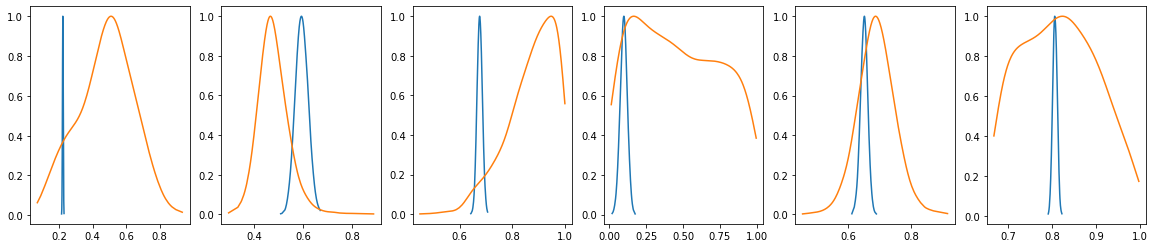

In [ ]:
from anesthetic.plot import kde_plot_1d
fig, axs = plt.subplots(1, 6, figsize=(20, 4))

param_lims = np.empty((0, 2))

for i in range(6):
    # kde_plot_1d(axs[i], utils[0].X_prior_tnsr[:, i].detach().to("cpu").numpy(), weibghts=X_prior_weights)
    kde_plot_1d(axs[i], util.XA_tnsr[:, i].detach().to("cpu").numpy(), weights=X0_weights)
    kde_plot_1d(axs[i], util.XB_tnsr[:, i].detach().to("cpu").numpy(), weights=X1_weights)
    param_lims = np.append(param_lims, [axs[i].viewLim.get_points()[:, 0]], axis=0)


(<matplotlib.tri.tricontour.TriContourSet at 0x7f0555f48850>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7f055b2ff090>)

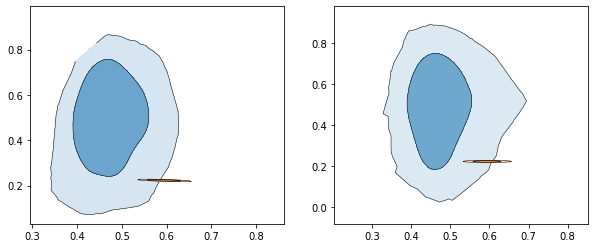

In [ ]:
from anesthetic.plot import kde_contour_plot_2d
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

XA_perm = utils[0].XA_tnsr.clone().detach()
XB_perm = utils[0].XB_tnsr.clone().detach()
X_prior_perm = utils[0].X_prior_tnsr.clone().detach()
XA_perm[:, 1] = XA_perm[torch.randperm(XA_perm.shape[0]), 1]
XB_perm[:, 1] = XB_perm[torch.randperm(XB_perm.shape[0]), 1]
# XA_perm[:, 1] = torch.rand(XA_perm.shape[0])
# XB_perm[:, 1] = torch.rand(XB_perm.shape[0])

kde_contour_plot_2d(axs[0], utils[0].XB_tnsr[:, 1].detach().to("cpu").numpy(), utils[0].XB_tnsr[:, 0].detach().to("cpu").numpy(), weights=X1_weights)
kde_contour_plot_2d(axs[0], utils[0].XA_tnsr[:, 1].detach().to("cpu").numpy(), utils[0].XA_tnsr[:, 0].detach().to("cpu").numpy(), weights=X0_weights)
# kde_plot_1d(axs[0], utils[0].XA_tnsr[:, 1].detach().to("cpu").numpy(), weights=X0_weights)
# kde_plot_1d(axs[0], utils[0].XB_tnsr[:, 1].detach().to("cpu").numpy(), weights=X1_weights)
kde_contour_plot_2d(axs[1], XB_perm[:, 1].detach().to("cpu").numpy(), XB_perm[:, 0].detach().to("cpu").numpy(), weights=X1_weights)
kde_contour_plot_2d(axs[1], XA_perm[:, 1].detach().to("cpu").numpy(), XA_perm[:, 0].detach().to("cpu").numpy(), weights=X0_weights)
# kde_plot_1d(axs[1], XA_perm[:, 1].detach().to("cpu").numpy(), weights=X0_weights)
# kde_plot_1d(axs[1], XB_perm[:, 1].detach().to("cpu").numpy(), weights=X1_weights)
